In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_format(title,xlabel,ylabel):
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=11, rotation=0)
    plt.yticks(fontsize=11)   

# READ DATA

## Origination Data

In [174]:
location = "/Users/xuduo/Desktop/Notes/Python/Python Projects/Data/sample_orig_"


column_names=['fico', 'dt_first_pi', 'flag_fthb', 'dt_matr', 'cd_msa', 
              'mi_pct', 'cnt_units','occpy_sts', 'cltv', 'dti', 
              'orig_upb', 'ltv', 'int_rt', 'channel', 'ppmt_pnlty',
              'prod_type', 'st', 'prop_type', 'zipcode', 'id_loan', 
              'loan_purpose','orig_loan_term', 'cnt_borr', 'seller_name', 'servicer_name', 
              'flag_sc','program_ind']

def quarter(time):
    if time == "01" or time == "02" or time == "03": 
        return 'Q1'
    elif time == "04" or time == "05" or time == "06": 
        return 'Q2'
    elif time == "07" or time == "08" or time == "09": 
        return 'Q3'
    else:
        return 'Q4'

def read_file(y):
    file = pd.read_csv(location + str(y) + '.txt', sep = '|', names = column_names,
                      low_memory = False) # Some columns have mixed types -> use low_memory = False
    file['year'] = file['dt_first_pi'].astype(str).str[:4]
    file['month'] = file['dt_first_pi'].astype(str).str[-2:]
    file['quarter'] = file['year'] + file['month'].apply(quarter)
    return file[file['year'].astype(int) <= 2009]

ori_2008 = read_file(2008)
ori_2009 = read_file(2009)

ori = pd.concat([ori_2008, ori_2009])

ori.to_csv("origination_2008_2009.csv",index=False)
print(ori.shape)

(91579, 30)


## Performance Data

In [175]:
location = "/Users/xuduo/Desktop/Notes/Python/Python Projects/Data/sample_svcg_"

column_names=['id_loan','Period','Act_endg_upb','delq_sts','loan_age',
              'mths_remng','repch_flag','flag_mod','CD_Zero_BAL','Dt_zero_BAL',
              'New_Int_rt','Amt_Non_Int_Brng_Upb','Dt_Lst_Pi','MI_Recoveries','Net_Sale_Proceed',
              'Non_MI_Recoveries','Expenses','legal_costs','maint_pres_costs','taxes_ins_costs',
              'misc_costs','actual_loss','modcost','stepmod_ind','dpm_ind', 
              'eltv','zb_removal_upb','dlq_acrd_int','disaster_hardship_ind','borrower_assist_flag']

chuck_size = 1000 # Help loading big data -> MapReduce

def read_file(y):
    mylist = []
    for chunk in pd.read_csv(location + str(y) + '.txt', sep = '|', names = column_names,
                      low_memory = False, chunksize = chuck_size): # run functions in different chunks (for loop)
        chunk = chunk[chunk['Period'] <= (y+5)*100] # Selet only 5-year performance for each loan
        mylist.append(chunk)
    per = pd.concat(mylist, axis = 0)
    return per

per_2008 = read_file(2008)
per_2009 = read_file(2009)

performance = pd.concat([per_2008, per_2009])

performance.to_csv("performance_2008_2009.csv",index=False)
print(performance.shape)

(3713474, 30)


# PROJECT 2: RISK/DELINQUENCY MODEL

## Load the data

In [3]:
# Load the data
ori = pd.read_csv("origination_2008_2009.csv",low_memory = False)
per = pd.read_csv("performance_2008_2009.csv",low_memory = False)

In [4]:
# Identify delinquency and combine per and ori

# 1. Add quarter and int_rt from ori
per_deli = pd.merge(ori[['id_loan', 'int_rt','quarter']], per, how = 'inner', on = 'id_loan') 

# 2. Define delinquency
# a. When a loan has 90+ days in delinquency or balance becomes zero
per_deli['delq_sts_num']=pd.to_numeric(per_deli['delq_sts'], errors='coerce') 
per_deli.loc[(per_deli['delq_sts_num'] > 2) | (per_deli['CD_Zero_BAL'].isin(['3.0','6.0','9.0'])),'bad'] = 1 

# b. When a loan has shown recovery amounts or deferred UPB
max_recovery = per_deli.groupby(['id_loan'])['Non_MI_Recoveries', 'MI_Recoveries', 'Amt_Non_Int_Brng_Upb'].max().reset_index()
per_deli = pd.merge(per_deli, max_recovery, on='id_loan')
per_deli.loc[(per_deli['delq_sts']=='R')| (per_deli['Non_MI_Recoveries_y'] > 0) | (per_deli['MI_Recoveries_y'] > 0 ) | 
             (per_deli['Amt_Non_Int_Brng_Upb_y'] > 0), 'bad']=1

# c. When a loan has been modified (such as when interest rate reduction)
per_deli.loc[(per_deli['flag_mod']=='Y'), 'bad']=1

min_new_int_rt = per_deli.groupby('id_loan')[['New_Int_rt']].min().reset_index()
per_deli = pd.merge(per_deli, min_new_int_rt, on='id_loan')
per_deli.loc[per_deli['New_Int_rt_y'] < per_deli['int_rt'], 'bad'] = 1

per_deli['deli']=np.where((per_deli['bad'] > 0), 1, 0)

# 3. Combine with ori
per_deli = per_deli.drop(['Non_MI_Recoveries_x','Non_MI_Recoveries_y','MI_Recoveries_x','MI_Recoveries_y',
                           'Amt_Non_Int_Brng_Upb_x','Amt_Non_Int_Brng_Upb_y','New_Int_rt_x','New_Int_rt_y','bad'], axis=1)
ori_per_deli = pd.merge(ori, per_deli.drop(['quarter','int_rt'],axis=1), how = "inner", on = "id_loan")
ori_per_deli.head()

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,modcost,stepmod_ind,dpm_ind,eltv,zb_removal_upb,dlq_acrd_int,disaster_hardship_ind,borrower_assist_flag,delq_sts_num,deli
0,735,200803,N,203802,44180.0,0,1,P,87,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
1,735,200803,N,203802,44180.0,0,1,P,87,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
2,735,200803,N,203802,44180.0,0,1,P,87,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
3,735,200803,N,203802,44180.0,0,1,P,87,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
4,735,200803,N,203802,44180.0,0,1,P,87,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0


In [5]:
# Check wether the 'bad' count is enough for modeling
# Check whether the bad rate makes sense

print(ori_per_deli.shape)
print(ori_per_deli['deli'].sum(),"\n")
print(ori_per_deli['deli'].groupby(ori_per_deli['quarter']).mean())

(3407832, 57)
123762 

quarter
2008Q1    0.091530
2008Q2    0.069314
2008Q3    0.071388
2008Q4    0.063545
2009Q1    0.026894
2009Q2    0.006621
2009Q3    0.005480
2009Q4    0.005763
Name: deli, dtype: float64


## Data Cleaning

In [6]:
# Remove the meaningless variables
df = ori_per_deli.drop(['dt_first_pi','dt_matr','cd_msa','prod_type','st','zipcode',
                        'seller_name','servicer_name','program_ind','year','month','quarter',
                        'mths_remng','repch_flag','flag_mod','stepmod_ind','Dt_zero_BAL','Dt_Lst_Pi',
                        'Net_Sale_Proceed','Expenses','legal_costs','maint_pres_costs','taxes_ins_costs',
                        'misc_costs','actual_loss','modcost','dpm_ind','eltv','zb_removal_upb','dlq_acrd_int',
                        'disaster_hardship_ind','borrower_assist_flag'],axis=1)
df.shape

(3407832, 25)

### Examine Numeric Variables

In [7]:
pd.options.display.float_format = "{:.2f}".format  # Change the float format
df.iloc[:,:15].describe(include=[np.number]) # Only look at the numerical variables

,fico,mi_pct,cnt_units,cltv,dti,orig_upb,ltv,int_rt
count,3407832.00,3407832.00,3407832.00,3407832.00,3407832.00,3407832.00,3407832.00,3407832.00
mean,751.47,3.20,1.03,69.71,46.05,197550.52,68.49,5.51
std,173.89,8.37,0.23,17.46,106.26,108633.79,17.46,0.73
min,300.00,0.00,1.00,6.00,1.00,6000.00,6.00,3.88
25%,717.00,0.00,1.00,60.00,25.00,113000.00,58.00,4.88
50%,760.00,0.00,1.00,75.00,34.00,175000.00,74.00,5.38
75%,788.00,0.00,1.00,80.00,44.00,261000.00,80.00,6.00
max,9999.00,37.00,4.00,999.00,999.00,934000.00,999.00,9.50


In [8]:
df.iloc[:,15:].describe(include=[np.number])

,orig_loan_term,cnt_borr,Period,Act_endg_upb,loan_age,CD_Zero_BAL,delq_sts_num,deli
count,3407832.00,3407832.00,3407832.00,3407832.00,3407832.00,60016.00,3406287.00,3407832.00
mean,328.10,1.57,201039.76,185157.03,21.98,1.14,0.17,0.04
std,67.62,1.34,135.37,108364.39,14.87,0.96,1.57,0.19
min,60.00,1.00,200802.00,0.00,0.00,1.00,0.00,0.00
25%,360.00,1.00,200910.00,103002.96,9.00,1.00,0.00,0.00
50%,360.00,2.00,201009.00,163000.00,20.00,1.00,0.00,0.00
75%,360.00,2.00,201111.00,249000.00,33.00,1.00,0.00,0.00
max,480.00,99.00,201312.00,934000.00,58.00,9.00,52.00,1.00


In [9]:
# Clean 1: Remove invalid values (Based on describe)
# ltv -> Original Loan-To-Value --> remove 999 for "not available"
# cltv -> Original Combined Loan-To-Value --> remove 999 for "not available"
# dti -> Original Debt-To_Income --> remove 999 for "not available"
# cnt_borr -> Number of Borrowers --> remove 99 for invalid value

df = df.loc[(df['ltv'] != 999) & (df['cltv'] != 999) & (df['dti'] != 999) & (df['cnt_borr'] < 99)]

df.describe(include=[np.number])

,fico,mi_pct,cnt_units,cltv,dti,orig_upb,ltv,int_rt,orig_loan_term,cnt_borr,Period,Act_endg_upb,loan_age,CD_Zero_BAL,delq_sts_num,deli
count,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,59199.00,3364463.00,3365968.00
mean,751.55,3.21,1.03,69.72,34.36,197440.11,68.49,5.51,327.99,1.55,201040.32,185041.50,21.98,1.14,0.17,0.04
std,174.88,8.39,0.23,17.34,12.46,108618.11,17.35,0.73,67.72,0.50,135.35,108337.05,14.87,0.95,1.56,0.19
min,300.00,0.00,1.00,6.00,1.00,6000.00,6.00,3.88,60.00,1.00,200802.00,0.00,0.00,1.00,0.00,0.00
25%,717.00,0.00,1.00,60.00,25.00,113000.00,58.00,4.88,360.00,1.00,200910.00,103000.00,9.00,1.00,0.00,0.00
50%,760.00,0.00,1.00,75.00,34.00,175000.00,74.00,5.38,360.00,2.00,201009.00,163000.00,20.00,1.00,0.00,0.00
75%,788.00,0.00,1.00,80.00,44.00,261000.00,80.00,6.00,360.00,2.00,201111.00,248717.32,33.00,1.00,0.00,0.00
max,9999.00,37.00,4.00,114.00,65.00,934000.00,100.00,9.50,480.00,2.00,201312.00,934000.00,58.00,9.00,52.00,1.00


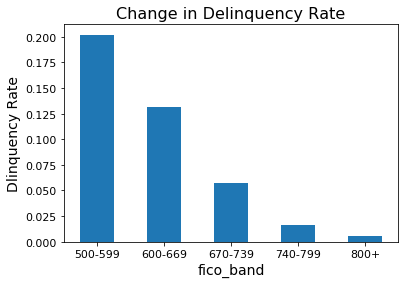

In [10]:
# Clean 2: Make derived variables

### Combine multiple variables
# Define FICO band --> format: '###-###'
# FICO < 600 is considered subprime, FICO >= 780 is considered excellent

def fico_band(fico):
    if fico < 600: 
        return '500-599'
    elif fico < 670:
        return '600-669'
    elif fico < 740:
        return '670-739'
    elif fico < 800:
        return '740-799'
    else:
        return '800+'

# Create the 'fico_band'
df.loc[:,'fico_band']=df.loc[:,'fico'].apply(fico_band)

# Calculate the average for each fico band
df.loc[:,'deli'].groupby(df.loc[:,'fico_band']).mean().plot(kind = 'bar')

plot_format('Change in Delinquency Rate','fico_band','Dlinquency Rate')
plt.show()

In [ ]:
### Transform a raw variable
df.loc[:,'other_debt_to_value']=df.loc[:,'cltv']-df.loc[:,'ltv']
df.loc[:,'other_debt_to_this_loan_ratio']=df.loc[:,'other_debt_to_value']/df.loc[:,'ltv']

### Create dummy variable
# As only 13.9% of loans have mortgage insurance
print("mi_pct>0:", 1-len(df[df.loc[:,'mi_pct']==0])/len(df))
df.loc[:,'mi_flag']=np.where(df.loc[:,'mi_pct'] > 0, 1, 0)

### Take a log of dollar amount
# - Dollar amount is usually quite skewed in distribution. A log transformation makes it closer to a normal distribution.
# - It can be used with the raw variable to form a 2-degree variable
df.loc[:,'orig_upb_log'] = df.loc[:,'orig_upb'].apply(lambda x: np.log(x))
df[['orig_upb', 'orig_upb_log','mi_pct','mi_flag']].describe()

mi_pct>0: 0.13923780618235226


In [ ]:
# Clean 3: Remove outlines
df.describe(include=[np.number], percentiles=(0.9, 0.95, 0.98, 0.99))

In [ ]:
# Cut each variable into bins of an equal distribution and see whether a monotonic trend emerges

num_list = ['fico','cltv','ltv','dti','orig_upb','Act_endg_upb']

for num in num_list:
    # cut x into 20 bins according to its value
    df.loc[:,'value_ranks']=pd.cut(df.loc[:,num], 20, labels = False)
    df.groupby(df.value_ranks).size().plot(kind='bar', color='blue')
    plot_format('',num,'')
    plt.show()

# Suppress the outliers for continuous values
df.loc[:,num_list].describe(percentiles=(0.25, 0.5, 0.9, 0.95, 0.98, 0.99))

In [ ]:
# Cap the outlier. I choose 98 percentile for each continuous variable
# It also depends on variable behavior, i.e., FICO > 800 shows no behavioral difference, so we cap FICO at 800

df.loc[:,'fico']=np.where(df.loc[:,'fico'] > 800, 800, df.loc[:,'fico'])
df.loc[:,'cltv']=np.where(df['cltv'] > 95, 95, df.loc[:,'cltv'])
df.loc[:,'ltv']=np.where(df['ltv'] > 95, 95, df.loc[:,'ltv'])
df.loc[:,'dti']=np.where(df['dti'] > 60, 60, df.loc[:,'dti'])
df.loc[:,'orig_upb']=np.where(df.loc[:,'orig_upb'] > 417000, 417000, df.loc[:,'orig_upb'])
df.loc[:,'Act_endg_upb']=np.where(df.loc[:,'Act_endg_upb'] > 414000, 414000, df.loc[:,'Act_endg_upb'])

# make sure all model variables have full coverage
# check whether outliers have been capped properly
df[num_list].describe(percentiles=[0.90,0.95, 0.98,0.99])

### Examine Character Variables

In [ ]:
# Collapsing a variable means changing the scale of a variable:
# putting them in class intervals / assigning ranks to the observations. 

char_list = ['flag_fthb','occpy_sts','channel','ppmt_pnlty','prop_type','loan_purpose','flag_sc']

for char in char_list:
    df['deli'].groupby(df[char]).mean().plot(kind = 'bar')
    plot_format('',char,'')
    plt.show()

In [ ]:
# Clean 4: Fix with missing values
# ppmt_pnlty and flag_sc contain missing values. They can be imputed easily.
# ppmt_pnlty [['N' nan]]
# flag_sc [[nan 'Y']]
df.loc[df.loc[:,'ppmt_pnlty'].isna(), 'ppmt_pnlty']='Y'
df.loc[df.loc[:,'flag_sc'].isna(), 'flag_sc']='N'

In [ ]:
# Clean 2: Make derived variables - Create dummary variable
df.loc[:,'investment_property'] = np.where(df.loc[:,'occpy_sts'] == "I",1,0)
df.loc[:,'prepay_penalty']=np.where(df.loc[:,'ppmt_pnlty'] == "Y",1,0)
df.loc[:,'super_conforming']=np.where(df.loc[:,'flag_sc'] == "Y",1,0)
df.loc[:,'purchase_refinance']=np.where(df.loc[:,'loan_purpose'] == "P",1,0)

# Review the updated variables:
for char in char_list:
    df.loc[:,'deli'].groupby(df.loc[:,char]).mean().plot(kind = 'bar')
    plot_format('',char,'')
    plt.show()

In [ ]:
# Clean 5: Drop unneeded variable from the sample

drop_col = ['flag_fthb','mi_pct','occpy_sts','flag_sc','channel','ppmt_pnlty', 'prop_type','id_loan', 'loan_purpose',
            'fico_band','other_debt_to_value','other_debt_to_this_loan_ratio','delq_sts','delq_sts_num',
            'Period','CD_Zero_BAL','value_ranks']


df_vif = df.drop(drop_col, axis=1)

In [248]:
# Clean 6: VIF analysis for multicollinearity

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_vif
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,19.62,fico
1,22.10,cnt_units
2,242.70,cltv
3,9.68,dti
4,44.33,orig_upb
5,241.98,ltv
6,72.50,int_rt
7,29.80,orig_loan_term
8,11.66,cnt_borr
9,38.92,Act_endg_upb


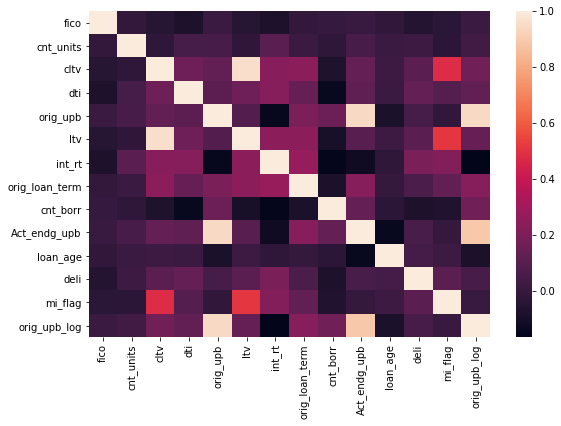

In [257]:
# check correlation
fig = plt.figure(figsize = (9,6))
sns.heatmap(df_vif.corr())
plt.show()

In [261]:
# Drop orig_upb_log, ltv and Act_endg_upb based on VIF result

df_model = df_vif.drop(['orig_upb_log','ltv','Act_endg_upb'], axis=1)
df_model.describe()

,fico,cnt_units,cltv,dti,orig_upb,int_rt,orig_loan_term,cnt_borr,loan_age,deli,mi_flag
count,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00
mean,751.55,1.03,69.72,34.36,197440.11,5.51,327.99,1.55,21.98,0.04,0.14
std,174.88,0.23,17.34,12.46,108618.11,0.73,67.72,0.50,14.87,0.19,0.35
min,300.00,1.00,6.00,1.00,6000.00,3.88,60.00,1.00,0.00,0.00,0.00
25%,717.00,1.00,60.00,25.00,113000.00,4.88,360.00,1.00,9.00,0.00,0.00
50%,760.00,1.00,75.00,34.00,175000.00,5.38,360.00,2.00,20.00,0.00,0.00
75%,788.00,1.00,80.00,44.00,261000.00,6.00,360.00,2.00,33.00,0.00,0.00
max,9999.00,4.00,114.00,65.00,934000.00,9.50,480.00,2.00,58.00,1.00,1.00


## Data Modeling

In [262]:
# Split the sample by 60/40 to make a modeling sample and a validation sample

# Use the following variable to split the smaple
df_model['random_temp']=np.random.uniform(0, 1, len(df_model))
split_pct=0.4

samp_train=df_model.loc[df_model['random_temp'] > split_pct]
samp_test=df_model.loc[df_model['random_temp'] <= split_pct]
samp_train.info()

# Second Method to split the sample:
# df_model['index'] = df_model.set_index()
# samp_train = df_model.sample(round(len(df_model)*split_pct))
# samp_test = df_model[~df_model['index'].isin (samp_train['index'])]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2019031 entries, 2 to 3407831
Data columns (total 12 columns):
fico              int64
cnt_units         int64
cltv              int64
dti               int64
orig_upb          int64
int_rt            float64
orig_loan_term    int64
cnt_borr          int64
loan_age          int64
deli              int64
mi_flag           int64
random_temp       float64
dtypes: float64(2), int64(10)
memory usage: 200.3 MB


### Logit Model

In [269]:
import statsmodels.api as sm

# Create the intercept variable 
samp_train['intercept']=1

# Or using add_constant()
# from statsmodels.tools import add_constant
# x_train = add_constant(x_train)

y_train = samp_train.loc[:,'deli']
x_train = samp_train.drop(['deli','random_temp'],axis=1)

logitreg = sm.Logit(y_train,x_train)

result = logitreg.fit()
result.summary()

         Current function value: 0.117948
         Iterations: 35


/Users/xuduo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   deli   No. Observations:              2019031
Model:                          Logit   Df Residuals:                  2019018
Method:                           MLE   Df Model:                           12
Date:                Thu, 17 Dec 2020   Pseudo R-squ.:                  0.2367
Time:                        15:08:09   Log-Likelihood:            -2.3814e+05
converged:                      False   LL-Null:                   -3.1198e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
fico               0.0104    564.784   1.85e-05      1.000   -1106.946    1106.966
cnt_units          0.0825   3973.788   2.08e-05      1.000   -7788.400    7788.564
cltv              -0.0275   1296.324  -2.12e-05      1.000   -2540.777    2540.722
dti               -0.0390   1891.557  -2.06e-05      1.000   -3707.422    3707.344
orig_upb       -4.562e-06      0.234  -1.95e-05      1.000      -0.458       0.458
int_rt            -1.1824   5.75e+04  -2.06e-05      1.000   -1.13e+05    1.13e+05
orig_loan_term    -0.0017     69.843  -2.45e-05      1.000    -136.892     136.888
cnt_borr           0.7575   3.78e+04      2e-05      1.000   -7.41e+04    7.41e+04
loan_age          -0.0198    995.875  -1.99e-05      1.000   -1951.898    1951.859
mi_flag           -0.1611   1.01e+04   -1.6e-05      1.000   -1.98e+04    1.98e+04
intercept         -0.4785   3.24e+05  -1.48e-06      1.000   -6.34e+05    6.34e+05
rawscore           0.9993   5.62e+04   1.78e-05      1.000    -1.1e+05     1.1e+05
default_score      4.6077      0.058     78.966      0.000       4.493       4.722
dist_ranks         0.6061      0.005    127.058      0.000       0.597       0.615
==================================================================================
"""

In [270]:
coef = result.params.values
print(coef,'\n')

samp_train.loc[:,'rawscore'] = (x_train * coef).sum(axis = 1)
samp_train.loc[:,'default_score']=samp_train.loc[:,'rawscore'].apply(lambda x:1/(1+np.exp(-1*x)))

print(samp_train[['deli', 'default_score']].mean())


[ 1.04230422e-02  8.24667742e-02 -2.74540062e-02 -3.89526706e-02
 -4.56150360e-06 -1.18236710e+00 -1.71300868e-03  7.57529490e-01
 -1.98123684e-02 -1.61129429e-01 -4.78547963e-01  9.99284060e-01
  4.60770592e+00  6.06058844e-01] 

deli            0.04
default_score   0.04
dtype: float64


            default_score  deli
dist_ranks                     
0                    0.00  0.00
1                    0.00  0.00
2                    0.00  0.00
3                    0.00  0.00
4                    0.01  0.01
5                    0.01  0.01
6                    0.02  0.02
7                    0.04  0.04
8                    0.07  0.08
9                    0.19  0.19
AxesSubplot(0.125,0.125;0.775x0.755)


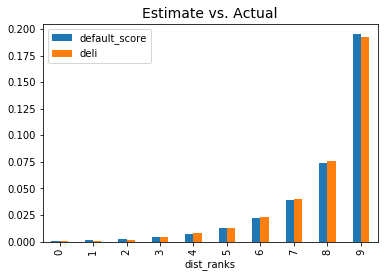

In [271]:
samp_train.loc[:,'dist_ranks']=pd.qcut(samp_train.loc[:,"default_score"], 10, labels=False, duplicates="drop")
rank_def_deli = samp_train[['default_score', 'deli']].groupby(samp_train['dist_ranks']).mean()
print(rank_def_deli)
print(rank_def_deli.plot(kind = 'bar'))

plt.title('Estimate vs. Actual', fontsize=14)
plt.show()

deli            0.04
default_score   0.04
dtype: float64
            default_score  deli
dist_ranks                     
0                    0.00  0.00
1                    0.00  0.00
2                    0.00  0.00
3                    0.00  0.00
4                    0.01  0.01
5                    0.01  0.01
6                    0.02  0.02
7                    0.04  0.04
8                    0.07  0.08
9                    0.19  0.20
AxesSubplot(0.125,0.125;0.775x0.755)


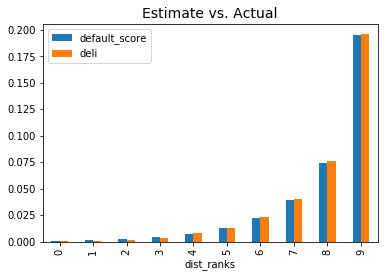

In [272]:
# Sample Validation

samp_test['intercept']=1

x_test = samp_test.drop(['deli','random_temp'],axis=1)

samp_test.loc[:,'rawscore'] = (x_test * coef).sum(axis=1)
samp_test.loc[:,'default_score']=samp_test.loc[:,'rawscore'].apply(lambda x:1/(1+np.exp(-1*x)))

print(samp_test[['deli', 'default_score']].mean())

samp_test.loc[:,'dist_ranks']=pd.qcut(samp_test.loc[:,"default_score"], 10, labels=False, duplicates="drop")
rank_def_deli = samp_test[['default_score', 'deli']].groupby(samp_test['dist_ranks']).mean()
print(rank_def_deli)
print(rank_def_deli.plot(kind = 'bar'))

plt.title('Estimate vs. Actual', fontsize=14)
plt.show()

In [274]:
# calculate KS statistics
samp_train.loc[:,'good']=1-samp_train.loc[:,'deli']
samp_test.loc[:,'good']=1-samp_test.loc[:,'deli']

In [277]:
# ks for training
samp_train.loc[:,'bucket'] = pd.qcut(samp_train.default_score, 10)
grouped = samp_train.groupby('bucket', as_index = False)

agg1 = grouped.min().default_score
agg2 = grouped.max().default_score
agg3 = grouped.count().default_score
agg4 = grouped.sum().deli
agg5 = grouped.sum().good

agg = pd.concat([agg1,agg2,agg3,agg4,agg5], axis=1)
agg.columns = ['min_scr','max_scr','total','bads','goods']

agg['bad_rate (%)'] = round(agg['bads'] / agg['total'] * 100,2)
agg['cum_bad_rate (%)'] = round(agg['bads'].cumsum() / agg['bads'].sum() * 100,2) # tpr
agg['cum_good_rate (%)'] = round(agg['goods'].cumsum() / agg['goods'].sum() * 100,2) # fpr
agg['ks'] = abs(agg['cum_bad_rate (%)'] - agg['cum_good_rate (%)'])
agg['max_ks'] = np.where(agg.ks == agg.ks.max(),"<-----","")

print("ks = ", round(max(agg.ks),2))
agg

ks =  57.89


,min_scr,max_scr,total,bads,goods,bad_rate (%),cum_bad_rate (%),cum_good_rate (%),ks,max_ks
0,0.00,0.00,201904,72,201832,0.04,0.10,10.37,10.27,
1,0.00,0.00,201903,181,201722,0.09,0.35,20.73,20.38,
2,0.00,0.00,201903,360,201543,0.18,0.85,31.08,30.23,
3,0.00,0.01,201903,804,201099,0.40,1.96,41.41,39.45,
4,0.01,0.01,201903,1572,200331,0.78,4.13,51.71,47.58,
5,0.01,0.02,201903,2617,199286,1.30,7.75,61.94,54.19,
6,0.02,0.03,201903,4662,197241,2.31,14.19,72.08,57.89,<-----
7,0.03,0.05,201903,8021,193882,3.97,25.27,82.04,56.77,
8,0.06,0.10,201903,15260,186643,7.56,46.35,91.62,45.27,
9,0.12,0.81,201903,38830,163073,19.23,100.00,100.00,0.00,


In [278]:
# ks for testing
samp_test['bucket'] = pd.qcut(samp_test.default_score, 10)
grouped = samp_test.groupby('bucket', as_index = False)
agg1 = grouped.min().default_score
agg2 = grouped.max().default_score
agg3 = grouped.count().default_score
agg4 = grouped.sum().deli
agg5 = grouped.sum().good

agg = pd.concat([agg1,agg2,agg3,agg4,agg5], axis=1)
agg.columns = ['min_scr','max_scr','total','bads','goods']

agg['bad_rate (%)'] = round(agg['bads'] / agg['total'] * 100,2)
agg['cum_bad_rate (%)'] = round(agg['bads'].cumsum() / agg['bads'].sum() * 100,2) # tpr
agg['cum_good_rate (%)'] = round(agg['goods'].cumsum() / agg['goods'].sum() * 100,2) # fpr
agg['ks'] = abs(agg['cum_bad_rate (%)'] - agg['cum_good_rate (%)'])
agg['max_ks'] = np.where(agg.ks == agg.ks.max(),"<-----","")

print("ks = ", round(max(agg.ks),2))
agg

# Meaning:
# If we choose 0.03 as cutoff (reject if the score lower than this value), we can reject 13.99% bad id correctly

# The bigger ks, the better result (separate good and bad id), but usually less than 52% (unless there is overfitting)

ks =  58.22


,min_scr,max_scr,total,bads,goods,bad_rate (%),cum_bad_rate (%),cum_good_rate (%),ks,max_ks
0,0.00,0.00,134694,49,134645,0.04,0.10,10.37,10.27,
1,0.00,0.00,134694,120,134574,0.09,0.35,20.74,20.39,
2,0.00,0.00,134693,240,134453,0.18,0.84,31.10,30.26,
3,0.00,0.01,134694,500,134194,0.37,1.86,41.43,39.57,
4,0.01,0.01,134694,1056,133638,0.78,4.03,51.73,47.70,
5,0.01,0.02,134693,1734,132959,1.29,7.58,61.97,54.39,
6,0.02,0.03,134694,3079,131615,2.29,13.89,72.11,58.22,<-----
7,0.03,0.05,134693,5424,129269,4.03,25.01,82.07,57.06,
8,0.06,0.10,134694,10212,124482,7.58,45.95,91.66,45.71,
9,0.12,0.81,134694,26367,108327,19.58,100.00,100.00,0.00,


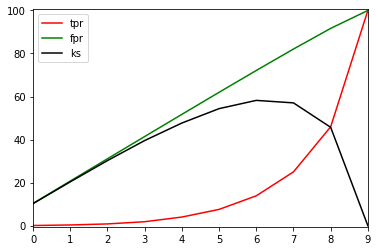

In [279]:
agg['cum_bad_rate (%)'].plot(label = 'tpr', c = 'red')
agg['cum_good_rate (%)'].plot(label = 'fpr', c = 'green')
agg['ks'].plot(label = 'ks', c = 'black')

plt.ylim([-0.5, 100.5])

plt.legend()

In [280]:
# The modeling exercise for this project has ended in the above section. 
# The following exercise is to compare logistic regression and decision tree only.

samp_train=df_model.loc[df_model['random_temp'] > split_pct]
samp_test=df_model.loc[df_model['random_temp'] <= split_pct]

x_train = samp_train.drop(['deli','random_temp'],axis=1)
y_train = samp_train['deli']

x_test = samp_test.drop(['deli','random_temp'],axis=1)
y_test = samp_test['deli']

### Logistic Regression


In [282]:
from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression(solver='lbfgs')
logreg.fit(x_train, y_train)

print("log_intercept:", logreg.intercept_)
print("log_coef:", logreg.coef_,"\n")

y_pred_proba = logreg.predict_proba(x_test)
y_pred = logreg.predict(x_test)

print("Predict Y by proability:\n", y_pred_proba)
print("Predict Y by class:\n",y_pred,'\n')

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))


log_intercept: [6.76992606e-05]
log_coef: [[-1.46504727e-02  1.87146353e-04  4.11201043e-02  3.65777129e-02
   2.28843064e-06  3.52007136e-03  5.41374938e-03 -1.06250503e-03
   2.02372320e-02  9.13137367e-04]] 

Predict Y by proability:
 [[9.72751365e-01 2.72486354e-02]
 [9.72209791e-01 2.77902093e-02]
 [9.71095103e-01 2.89048971e-02]
 ...
 [9.99676258e-01 3.23742443e-04]
 [9.99669641e-01 3.30358650e-04]
 [9.99662890e-01 3.37110025e-04]]
Predict Y by class:
 [0 0 0 ... 0 0 0] 

Accuracy of logistic regression classifier on test set: 0.96


In [285]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

# prepare the cross-validation procedure
cv = model_selection.KFold(n_splits=10, random_state=7)

# create model
model = LogisticRegression(solver='lbfgs',max_iter=5) # If error -> increase max_iter

# evaluate model
scores = model_selection.cross_val_score(model, x_train, y_train, scoring='accuracy', cv=cv)

# report performance
print("10-fold cross validation average accuracy: %.3f" % (scores.mean()))

10-fold cross validation average accuracy: 0.964


In [286]:
### Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_matrix,"\n")

print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[1297673     483]
 [  48520     261]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98   1298156
           1       0.35      0.01      0.01     48781

    accuracy                           0.96   1346937
   macro avg       0.66      0.50      0.50   1346937
weighted avg       0.94      0.96      0.95   1346937



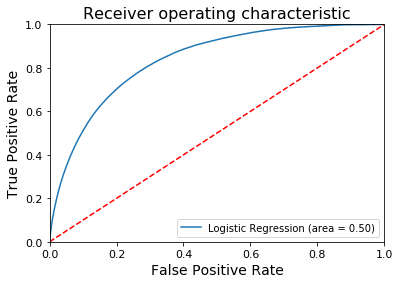

In [288]:
### ROC_AUC Score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])

plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plot_format('Receiver operating characteristic','False Positive Rate','True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Decision Tree

In [289]:
from sklearn import tree
from sklearn.metrics import accuracy_score

deci_tree = tree.DecisionTreeClassifier(criterion = "gini", # default -> or criterion = "entropy"
                                        random_state = 100,
                                        max_depth = 18,
                                        min_samples_leaf = 5) # min_sample required to be at a leaf node

deci_tree.fit(x_train, y_train)
y_pred = deci_tree.predict(x_test)
print ("Accuracy is {:.2f}".format(accuracy_score(y_test,y_pred)))

Accuracy is 0.99


In [290]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99   1298156
           1       0.93      0.76      0.84     48781

    accuracy                           0.99   1346937
   macro avg       0.96      0.88      0.92   1346937
weighted avg       0.99      0.99      0.99   1346937

